## Outline
1. [Problem Statement](#problem-statement)
2. [Data Sources](#data-sources)
3. [Compile the Dataset](#compile-the-dataset)
4. [Summarize the Dataset](#summarize-the-dataset)
5. [Address Missing Values](#address-missing-values)
6. [Exploratory Analysis](#exploratory-analysis)
7. [Feature Engineering](#feature-engineering)
8. [Build and Evaluate a Classification Model](#build-a-classification-model)
9. [Build and Evaluate a Regression Model](#build-a-regression-model)
10. [Feature Selection](#feature-selection)
11. [The Regression Model](#regression-model)
12. [Interpret Coefficients](#interpret-coefficients)
13. [Conclusions and Summary](#conclusions)

<a id="problem-statement"></a>
## Problem Statement

Determine whether there is an association between extreme weather event fatalities and certain storm and location characteristics. Are there specific features that increase the likelihood of fatalities?

### Hypothesis

The type of storm, magnitude, and extent of property damage are most closely associated with number of fatalities.

### Approach

 - Build a classification model that predicts whether or not a storm event results in fatalities
 - Then build a regression model that predicts the number of fatalities
 
### Limitations

 - Missing data that likely influences the outcome includes quality of state emergency response, demographics, number of shelters, etc. 



<a id="data-sources"></a>
## Data Sources


- [Storm Events Database:](#https://www.ncdc.noaa.gov/stormevents/) NOAA,  (2016 - 2018)
  - Extreme weather events
  - Fatalities


- U.S. Census Bureau
  - [State Population](#https://www.census.gov/newsroom/press-kits/2018/pop-estimates-national-state.html) (2015-2018 Annual Average)
  - [Age Breakdown](#https://www.census.gov/data/tables/2017/demo/popest/state-detail.html) (percent of population above 18 years)
  - [Urban/Rural Breakdown](#https://www.census.gov/geo/reference/ua/urban-rural-2010.html) (percent of population in urban areas)
  
  
- U.S. Bureau of Economic Analysis
  - [State GDP](#https://apps.bea.gov/regional/downloadzip.cfm) (Millions of Dollars)


- Agnes, Anna R., "Homeland Security/Emergency Management Budgets by Each U.S. State: Why do some states allocate so much more money than others do?" (2018). Political Science. 26.
  - [FY17 State Budgets for Emergency Management](#https://scholarsarchive.library.albany.edu/cgi/viewcontent.cgi?article=1025&context=honorscollege_pos) (USD)

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import random

<a id="compile-the-dataset"></a>
## The Dataset

The dataset is compiled from the above mentioned sources. After addressing null values, there are 158,412 observations, with each observation representing an extreme weather event. The final dataset has 23 features:
 - State
 - Year
 - Month
 - Event type
 - Injuries direct
 - Injuries indirect
 - Magnitude
 - Days
 - Duration (hours)
 - Budget (USD): State emergency budgets for FY17
 - Average Annual State Population over years 2016 through 2018
 - 3 year average: Annual 3 year average state GDP over 2016 through 2018
 - PCT18+: percent of population above 18 years of age
 - POPPCT_URBAN: percent of population residing in urban areas
 - Crop damage (1,000 USD)
 - Property damage (1,000 USD)
 - And seven dummy variables representing broader storm event type categories:
   - flood_rain
   - heat
   - ocean
   - other
   - tropical
   - wind_dust
   - winter
   
The following code in this section reads in the different datasets and compiles them into one dataframe. 

In [124]:
#Read in NOAA data on extreme weather events for years 2016 through 2018
storm18 = pd.read_csv('StormEvents_details-ftp_v1.0_d2018_c20190220.csv.gz')
storm17 = pd.read_csv('StormEvents_details-ftp_v1.0_d2017_c20181219.csv.gz')
storm16 = pd.read_csv('StormEvents_details-ftp_v1.0_d2016_c20180718.csv.gz')
df = pd.concat([storm18, storm17, storm16])
df.shape

(171758, 51)

In [125]:
# Feature engineering to simplify some columns to Days and Duration columns

df['Days'] = abs(df['END_DAY'] - df['BEGIN_DAY'])+1
df['Duration'] = abs(df['END_TIME'] - df['BEGIN_TIME'])

In [126]:
# Drop a bunch of columns that are repetitive or only apply to a small portion of the dataset
x = ['CATEGORY', 'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'FLOOD_CAUSE', 'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION','END_RANGE', 'END_AZIMUTH', 'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'EPISODE_NARRATIVE', 'BEGIN_YEARMONTH','BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH', 'END_DAY', 'END_TIME', 'EPISODE_ID', 'STATE_FIPS', 'CZ_TYPE','CZ_FIPS', 'CZ_NAME', 'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME','SOURCE', 'MAGNITUDE_TYPE','DATA_SOURCE','EVENT_NARRATIVE']
for i in x:
    df.drop([i], axis=1, inplace=True)

In [127]:
df.dtypes

EVENT_ID               int64
STATE                 object
YEAR                   int64
MONTH_NAME            object
EVENT_TYPE            object
INJURIES_DIRECT        int64
INJURIES_INDIRECT      int64
DEATHS_DIRECT          int64
DEATHS_INDIRECT        int64
DAMAGE_PROPERTY       object
DAMAGE_CROPS          object
MAGNITUDE            float64
Days                   int64
Duration               int64
dtype: object

In [128]:
# Read in second dataset on fatalties, where each observation represents one fatality
fata18 = pd.read_csv('StormEvents_fatalities-ftp_v1.0_d2018_c20190220.csv.gz')
fata17 = pd.read_csv('StormEvents_fatalities-ftp_v1.0_d2017_c20181219.csv.gz')
fata16 = pd.read_csv('StormEvents_fatalities-ftp_v1.0_d2016_c20180718.csv.gz')
fata = pd.concat([fata18, fata17, fata16])

#I chose to count number of fatalities by FATALITY_DATE because there were no null values in that column. 
df_fata = pd.DataFrame({'Num_fatalities': fata.groupby('EVENT_ID')['FATALITY_DATE'].count()})
df_fata.sort_values(['EVENT_ID'])
df_fata['Num_fatalities'].sum()

2190

In [129]:
#Check to make sure EVENT_ID is a unique id before merging with fatalities dataset. 
df['EVENT_ID'].nunique()==df['EVENT_ID'].count()

True

In [130]:
df.set_index('EVENT_ID', inplace=True)

In [131]:
#Merge dataframes with an outer join and delete DEATHS columns
df_new = df.join(df_fata, on='EVENT_ID', how='left')
df_new.drop(['DEATHS_DIRECT', 'DEATHS_INDIRECT'], axis=1, inplace=True)

In [132]:
df_new.shape #this join was OK

(171758, 12)

In [133]:
# Read in dataset on state budget for Emergency Management in FY17. For the purposes of this project, I assume
# this budget represents the annual average budget for emergency and disaster relief over years 2016 to 2018.
budget = pd.read_csv('StateBudget.csv')
budget.dtypes

STATE     object
Budget    object
dtype: object

In [134]:
# Change Budget into a float variable
budget['Budget'] = [x.strip() for x in budget['Budget']]
budget['Budget'] = budget['Budget'].str.replace(',', '')
budget['Budget'] = budget['Budget'].astype('float')

In [135]:
budget.dtypes

STATE      object
Budget    float64
dtype: object

In [136]:
# Join budget with the dataset.
df_new = df_new.merge(budget, on='STATE', how='left')

In [137]:
df_new.shape

(171758, 13)

In [138]:
# Read in data ....!!!!
popn =  pd.read_csv('popn.csv')
gdp = pd.read_csv('GDP.csv')
age = pd.read_csv('Age.csv')
urban = pd.read_csv('UrbanRural.csv')

In [139]:
urban.dtypes

STATE            object
POPPCT_URBAN    float64
dtype: object

In [140]:
df_new.isna().sum()

STATE                     0
YEAR                      0
MONTH_NAME                0
EVENT_TYPE                0
INJURIES_DIRECT           0
INJURIES_INDIRECT         0
DAMAGE_PROPERTY       33842
DAMAGE_CROPS          33729
MAGNITUDE             79082
Days                      0
Duration                  0
Num_fatalities       170482
Budget                13346
dtype: int64

In [141]:
# Merge onto dataset
l = [popn, gdp, age, urban]
for i in l:
    #print(i['STATE'])
    df_new = df_new.merge(i, on='STATE', how='left')

<a id="summarize-the-dataset"></a>
## Summarize the Dataset

In [142]:
df_new.shape

(171758, 17)

In [143]:
df_new.columns

Index(['STATE', 'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'INJURIES_DIRECT',
       'INJURIES_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'MAGNITUDE',
       'Days', 'Duration', 'Num_fatalities', 'Budget', 'AveragePopn16_18',
       '3yraverage', 'PCT18+', 'POPPCT_URBAN'],
      dtype='object')

In [144]:
df_new.head()

,STATE,YEAR,MONTH_NAME,EVENT_TYPE,INJURIES_DIRECT,INJURIES_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,MAGNITUDE,Days,Duration,Num_fatalities,Budget,AveragePopn16_18,3yraverage,PCT18+,POPPCT_URBAN
0,NEBRASKA,2018,June,Hail,0,0,0.00K,0.00K,1.00,1,0,NaN,1402870.0,1.917589e+06,117046.7333,75.2,73.13
1,NEBRASKA,2018,June,Hail,0,0,0.00K,0.00K,1.25,1,0,NaN,1402870.0,1.917589e+06,117046.7333,75.2,73.13
2,VERMONT,2018,June,Thunderstorm Wind,0,0,15.00K,0.00K,60.00,1,2,NaN,12567768.0,6.248227e+05,31590.1000,81.3,38.90
3,VERMONT,2018,June,Thunderstorm Wind,0,0,10.00K,0.00K,55.00,1,0,NaN,12567768.0,6.248227e+05,31590.1000,81.3,38.90
4,NEBRASKA,2018,June,Tornado,0,0,0.00K,0.00K,NaN,1,0,NaN,1402870.0,1.917589e+06,117046.7333,75.2,73.13


<a id="address-missing-values"></a>
## Address Missing Values

In [145]:
df_new.isna().sum()

STATE                     0
YEAR                      0
MONTH_NAME                0
EVENT_TYPE                0
INJURIES_DIRECT           0
INJURIES_INDIRECT         0
DAMAGE_PROPERTY       33842
DAMAGE_CROPS          33729
MAGNITUDE             79082
Days                      0
Duration                  0
Num_fatalities       170482
Budget                13346
AveragePopn16_18       7363
3yraverage             7864
PCT18+                 7864
POPPCT_URBAN           7363
dtype: int64

In [146]:
# ASSUMPTION: No fatalities data for a given event means there were zero fatalities.
df_new['Num_fatalities'].fillna(value=0, inplace=True)

In [147]:
# DECISION
# 1) Fill Nulls in Damage columns with 0.00K
# 2) Convert to floats

df_new['DAMAGE_PROPERTY'].fillna(value='0.00K', inplace=True)
df_new['DAMAGE_CROPS'].fillna(value='0.00K', inplace = True)

In [148]:
df_new['crop_dam'] = df_new['DAMAGE_CROPS'].apply(lambda x: float(x[:-1]))

In [149]:
df_new['prop_dam'] = df_new['DAMAGE_PROPERTY'].apply(lambda x: float(x[:-1]))

In [150]:
df_new.drop(['DAMAGE_PROPERTY', 'DAMAGE_CROPS'], axis= 1, inplace=True)

C:\Users\allis\Anaconda3\envs\py36\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\allis\Anaconda3\envs\py36\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


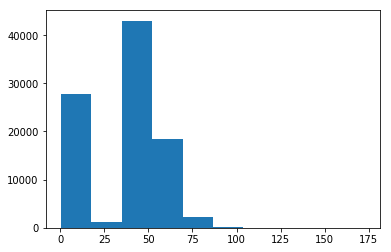

In [151]:
import matplotlib.pyplot as plt
plt.hist([df_new['MAGNITUDE']]);

In [152]:
# DECISION: Replace null values of magnitude with the median value. 
df_new['MAGNITUDE'].fillna(value=df_new['MAGNITUDE'].median(), inplace=True)

In [153]:
# Noting that the original dataset contained some areas that were not states...
df_new['STATE'][(df_new['Budget'].isna())].unique()

array(['GULF OF MEXICO', 'LAKE MICHIGAN', 'NORTH CAROLINA',
       'ATLANTIC NORTH', 'ATLANTIC SOUTH', 'LAKE SUPERIOR',
       'DISTRICT OF COLUMBIA', 'HAWAII WATERS', 'NEW HAMPSHIRE',
       'PUERTO RICO', 'E PACIFIC', 'AMERICAN SAMOA', 'LAKE ERIE',
       'LAKE HURON', 'LAKE ONTARIO', 'VIRGIN ISLANDS', 'ST LAWRENCE R',
       'LAKE ST CLAIR', 'GUAM'], dtype=object)

In [154]:
# However, there are only 5 datapoints of fatalities within these areas
df_new['Num_fatalities'][(df_new['Budget'].isna())].unique()

array([0., 2., 1., 4., 9., 3.])

In [155]:
# For this reason, I decided to drop the rows where Budget is null and limit the analysis to States only 
df_new.dropna(subset=['Budget'], axis=0, inplace=True)

In [156]:
df_new.isna().sum()

STATE                0
YEAR                 0
MONTH_NAME           0
EVENT_TYPE           0
INJURIES_DIRECT      0
INJURIES_INDIRECT    0
MAGNITUDE            0
Days                 0
Duration             0
Num_fatalities       0
Budget               0
AveragePopn16_18     0
3yraverage           0
PCT18+               0
POPPCT_URBAN         0
crop_dam             0
prop_dam             0
dtype: int64

<a id="exploratory-analysis"></a>
## Exploratory Analysis

In [35]:
df_new.dtypes

STATE                 object
YEAR                   int64
MONTH_NAME            object
EVENT_TYPE            object
INJURIES_DIRECT        int64
INJURIES_INDIRECT      int64
MAGNITUDE            float64
Days                   int64
Duration               int64
Num_fatalities       float64
Budget               float64
AveragePopn16_18     float64
3yraverage           float64
PCT18+               float64
POPPCT_URBAN         float64
crop_dam             float64
prop_dam             float64
dtype: object

In [36]:
df_new.columns

Index(['STATE', 'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'INJURIES_DIRECT',
       'INJURIES_INDIRECT', 'MAGNITUDE', 'Days', 'Duration', 'Num_fatalities',
       'Budget', 'AveragePopn16_18', '3yraverage', 'PCT18+', 'POPPCT_URBAN',
       'crop_dam', 'prop_dam'],
      dtype='object')

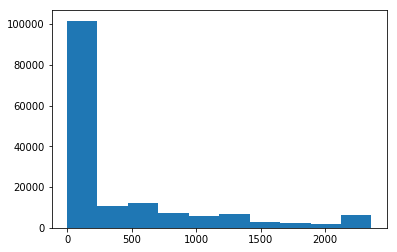

In [37]:
plt.hist([df_new['Duration']]);

In [159]:
df_new.sort_values(by="Num_fatalities", ascending=False).head()

,STATE,YEAR,MONTH_NAME,EVENT_TYPE,INJURIES_DIRECT,INJURIES_INDIRECT,MAGNITUDE,Days,Duration,Num_fatalities,Budget,AveragePopn16_18,3yraverage,PCT18+,POPPCT_URBAN,crop_dam,prop_dam
56741,CALIFORNIA,2018,November,Wildfire,0,12,50.0,18,867,86.0,60159500.0,39388507.00,2.673361e+06,77.1,94.95,0.0,17.0
109592,TEXAS,2017,August,Flash Flood,0,0,50.0,4,55,38.0,21481000.0,28320684.67,1.593159e+06,74.0,84.70,100.0,10.0
115186,TEXAS,2017,August,Tropical Storm,0,0,50.0,5,0,38.0,21481000.0,28320684.67,1.593159e+06,74.0,84.70,0.0,10.0
156544,NEVADA,2016,July,Excessive Heat,0,0,50.0,8,2359,26.0,4479751.0,2975523.00,1.508069e+05,77.1,94.20,0.0,0.0
97483,FLORIDA,2017,September,Tropical Storm,0,0,50.0,2,700,21.0,331052744.0,20968706.33,9.364919e+05,80.0,91.16,0.0,0.0


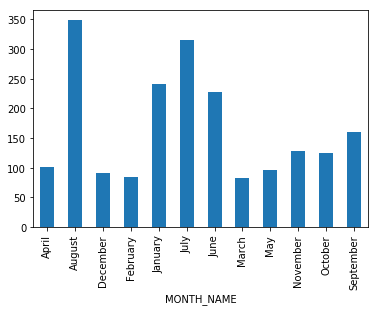

In [39]:
df_new.groupby('MONTH_NAME')['Num_fatalities'].sum().plot(kind='bar');

In [40]:
df_new.groupby('EVENT_TYPE')['Num_fatalities'].sum().sort_values(ascending=False).head()

EVENT_TYPE
Heat              248.0
Flash Flood       242.0
Excessive Heat    217.0
Tropical Storm    134.0
Winter Weather    131.0
Name: Num_fatalities, dtype: float64

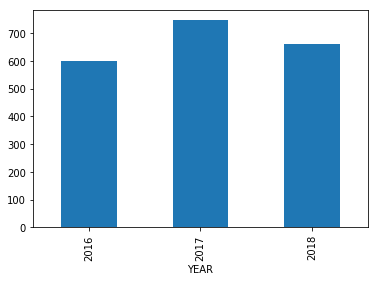

In [41]:
df_new.groupby('YEAR')['Num_fatalities'].sum().plot(kind='bar')

Fatalities are roughly the same year to year, so I don't expect year to be a differentiating feature. 

In [42]:
df_new.groupby('STATE')['Num_fatalities'].sum().sort_values(ascending=False).head()

STATE
NEVADA        332.0
TEXAS         291.0
FLORIDA       222.0
CALIFORNIA    214.0
WISCONSIN      83.0
Name: Num_fatalities, dtype: float64

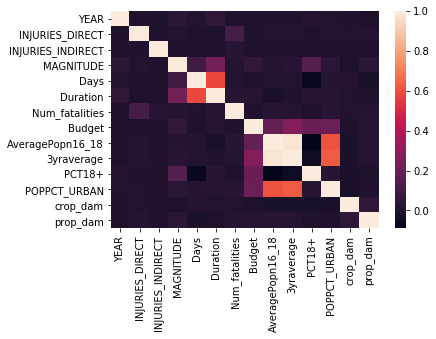

In [43]:
sns.heatmap(df_new.corr());

<a id="feature-engineering"></a>
## Feature Engineering

In this section, I simplified and condensed the event types into seven broad categories. I then made these types into dummy variables, given that scikit learn only takes numerical inputs. 

I also created a new column, 'fatalities,' which is a dummy variable coded 1 if the event resulted in fatalities, and 0 if not. 

In [160]:
# The number of unique event types in the dataset, and the corresponding number of fatalities. 
df_new.groupby('EVENT_TYPE')['Num_fatalities'].nunique()

EVENT_TYPE
Astronomical Low Tide       1
Avalanche                   3
Blizzard                    3
Coastal Flood               2
Cold/Wind Chill             5
Debris Flow                 2
Dense Fog                   3
Dense Smoke                 1
Drought                     1
Dust Devil                  1
Dust Storm                  3
Excessive Heat             14
Extreme Cold/Wind Chill     3
Flash Flood                11
Flood                       4
Freezing Fog                2
Frost/Freeze                1
Funnel Cloud                1
Hail                        2
Heat                       11
Heavy Rain                  3
Heavy Snow                  3
High Surf                   4
High Wind                   4
Hurricane                   7
Hurricane (Typhoon)         1
Ice Storm                   2
Lake-Effect Snow            3
Lakeshore Flood             2
Lightning                   4
Rip Current                 4
Seiche                      1
Sleet                       2

In [46]:
df_new['EVENT_TYPE'].unique()

array(['Hail', 'Thunderstorm Wind', 'Tornado', 'Flash Flood', 'Flood',
       'Lightning', 'Funnel Cloud', 'Drought', 'Wildfire',
       'Winter Weather', 'High Wind', 'Strong Wind', 'Debris Flow',
       'Rip Current', 'Winter Storm', 'Coastal Flood', 'Heavy Snow',
       'Avalanche', 'Dense Fog', 'Heavy Rain', 'Ice Storm',
       'Astronomical Low Tide', 'Cold/Wind Chill', 'High Surf',
       'Lake-Effect Snow', 'Dust Storm', 'Blizzard', 'Frost/Freeze',
       'Sleet', 'Extreme Cold/Wind Chill', 'Heat', 'Freezing Fog',
       'Storm Surge/Tide', 'Tropical Depression', 'Excessive Heat',
       'Lakeshore Flood', 'Dust Devil', 'Tropical Storm', 'Dense Smoke',
       'Seiche', 'Volcanic Ashfall', 'Sneakerwave', 'Hurricane',
       'Hurricane (Typhoon)'], dtype=object)

In [47]:
winter = ['Hail', 'Avalanche', 'Blizzard', 'Cold/Wind Chill', 'Extreme Cold/Wind Chill', 'Freezing Fog', 'Frost/Freeze', 'Heavy Snow', 'Ice Storm', 'Lake-Effect Snow', 'Sleet', 'Winter Storm', 'Winter Weather']
flood_rain = ['Flood','Debris Flow', 'Seiches', 'Coastal Flood','Flash Flood','Lakeshore Flood','Heavy Rain']
fire = ['Dense Smoke', 'Wildfire']
heat = ['Excessive Heat', 'Heat', 'Drought']
wind_dust = ['Dust Storm','Dust Devil','Funnel Cloud','High Wind','Strong Wind','Thunderstorm Wind', 'Tornado']
ocean = ['Astronomical Low Tide', 'High Surf', 'Rip Current', 'Sneakerwave', 'Storm Surge/Tide', 'Seiche']
tropical = ['Hurricane', 'Hurricane (Typhoon)', 'Tropical Depression', 'Tropical Storm', 'Marine Hurricane/Typhoon', 'Marine Tropical Depression', 'Marine Dense Fog']
other = ['Lightning', 'Dense Fog','Volcanic Ashfall']
a = [winter, flood_rain, fire, heat, wind_dust, ocean, tropical, other]

In [48]:
df_new['EVENT_TYPE'].replace(to_replace = winter, value = 'winter', inplace = True)
df_new['EVENT_TYPE'].replace(to_replace = flood_rain, value = 'flood_rain', inplace = True)
df_new['EVENT_TYPE'].replace(to_replace = fire, value = 'fire', inplace = True)
df_new['EVENT_TYPE'].replace(to_replace = heat, value = 'heat', inplace = True)
df_new['EVENT_TYPE'].replace(to_replace = wind_dust, value = 'wind_dust', inplace = True)
df_new['EVENT_TYPE'].replace(to_replace = ocean, value = 'ocean', inplace = True)
df_new['EVENT_TYPE'].replace(to_replace = tropical, value = 'tropical', inplace = True)
df_new['EVENT_TYPE'].replace(to_replace = other, value = 'other', inplace = True)

In [49]:
df_new['EVENT_TYPE'].head()

0       winter
1       winter
2    wind_dust
3    wind_dust
4    wind_dust
Name: EVENT_TYPE, dtype: object

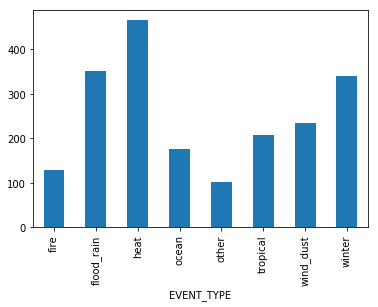

In [50]:
df_new.groupby('EVENT_TYPE')['Num_fatalities'].sum().plot(kind='bar')

In [51]:
type_dummies = pd.get_dummies(df_new.EVENT_TYPE, prefix='TYPE')
type_dummies.columns[0] #Baseline is fire

'TYPE_fire'

In [52]:
type_dummies.drop(type_dummies.columns[0], axis=1, inplace=True) #Fire is the baseline
type_dummies.sample(n=5, random_state=1)

,TYPE_flood_rain,TYPE_heat,TYPE_ocean,TYPE_other,TYPE_tropical,TYPE_wind_dust,TYPE_winter
93380,0,0,0,0,0,0,0
57713,0,0,0,0,0,1,0
75927,0,0,0,0,0,0,1
104675,0,1,0,0,0,0,0
47245,1,0,0,0,0,0,0


In [53]:
df_new = pd.concat([df_new, type_dummies], axis=1)

In [54]:
# Create a dummy column 1/0 for fatalities
df_new['fatalities']= df_new['Num_fatalities']>0

In [55]:
df_new.head()

,STATE,YEAR,MONTH_NAME,EVENT_TYPE,INJURIES_DIRECT,INJURIES_INDIRECT,MAGNITUDE,Days,Duration,Num_fatalities,...,crop_dam,prop_dam,TYPE_flood_rain,TYPE_heat,TYPE_ocean,TYPE_other,TYPE_tropical,TYPE_wind_dust,TYPE_winter,fatalities
0,NEBRASKA,2018,June,winter,0,0,1.00,1,0,0.0,...,0.0,0.0,0,0,0,0,0,0,1,False
1,NEBRASKA,2018,June,winter,0,0,1.25,1,0,0.0,...,0.0,0.0,0,0,0,0,0,0,1,False
2,VERMONT,2018,June,wind_dust,0,0,60.00,1,2,0.0,...,0.0,15.0,0,0,0,0,0,1,0,False
3,VERMONT,2018,June,wind_dust,0,0,55.00,1,0,0.0,...,0.0,10.0,0,0,0,0,0,1,0,False
4,NEBRASKA,2018,June,wind_dust,0,0,50.00,1,0,0.0,...,0.0,0.0,0,0,0,0,0,1,0,False


<a id="build-a-classification-model"></a>
## Build and Evaluate a Classification Model

I chose to use a Random Forest Classifier model because it is one of the better performing classification models. I excluded year, state, and month variables from the feature columns because the exploratory analysis did not suggest that these variables were particularly significant. 

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
#Instantiate
rfc = RandomForestClassifier()

#Define X and y
feature_cols=['INJURIES_DIRECT', 'INJURIES_INDIRECT', 'MAGNITUDE', 'Days', 'Duration', 'Budget', 'AveragePopn16_18', '3yraverage','PCT18+','POPPCT_URBAN','crop_dam','prop_dam','TYPE_flood_rain','TYPE_heat','TYPE_ocean','TYPE_other','TYPE_tropical','TYPE_wind_dust','TYPE_winter']
X = df_new[feature_cols]
y = df_new['fatalities']

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Fit
rfc.fit(X_train, y_train)

#Predict
y_pred = rfc.predict(X_test)

C:\Users\allis\Anaconda3\envs\py36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [58]:
# Check accuracy
metrics.accuracy_score(y_test, y_pred)

0.9936115950811807

In [59]:
# See which features are most important 
feature_imp = pd.Series(rfc.feature_importances_, index=feature_cols).sort_values(ascending=False)

In [60]:
print(feature_imp)

Duration             0.291376
prop_dam             0.134231
Days                 0.084058
INJURIES_DIRECT      0.056581
POPPCT_URBAN         0.052862
AveragePopn16_18     0.046204
3yraverage           0.044935
MAGNITUDE            0.044341
Budget               0.043600
PCT18+               0.042103
INJURIES_INDIRECT    0.040787
TYPE_ocean           0.028174
TYPE_winter          0.017836
TYPE_heat            0.016251
TYPE_flood_rain      0.015827
crop_dam             0.015504
TYPE_other           0.009891
TYPE_tropical        0.008486
TYPE_wind_dust       0.006952
dtype: float64


In [61]:
# Cross Validate
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')
mean = cross_val_score(rfc, X, y, cv=10, scoring='accuracy').mean()

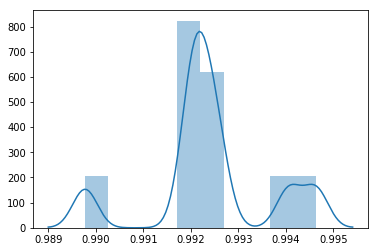

In [62]:
sns.distplot(scores, bins=10)

In [63]:
mean

0.9925005842326202

<a id="build-a-regression-model"></a>
## Build and Evaluate a Regression Model

Using the predicted y values from the classification model, I built a regression model to predict the number of fatalities. 

In [75]:
# Add y_pred to the dataframe
y_predictions = pd.DataFrame({'y_pred': y_pred})
df_new = df_new.join(y_predictions)
df_new.head()

In [90]:
# Create another dataframe consisting only of 'true' y-prediction values, and use it to build the model
df_2 = df_new[(df_new['y_pred']==True)]

In [99]:
df_2.shape

(140, 26)

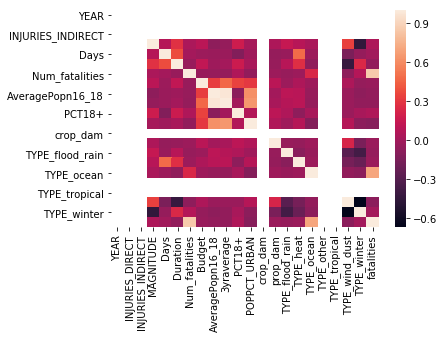

In [103]:
sns.heatmap(df_2.corr())

<a id="feature-selection"></a>
## Feature Selection for Regression

In [94]:
def train_test_rmse(feature_cols):
    X_r = df_2[feature_cols]
    y_r = df_2['Num_fatalities']
    X_train, X_test, y_train, y_test = train_test_split(X_r, y_r, random_state=1)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred_r = linreg.predict(X_test)
    
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred_r))

In [95]:
cols = ['INJURIES_DIRECT', 'INJURIES_INDIRECT', 'MAGNITUDE', 'Days', 'Budget', 'AveragePopn16_18', '3yraverage', 'PCT18+', 'POPPCT_URBAN', 'crop_dam', 'prop_dam', 'TYPE_flood_rain', 'TYPE_heat', 'TYPE_ocean', 'TYPE_other', 'TYPE_tropical', 'TYPE_wind_dust', 'TYPE_winter']
data=[]
for i in range(2,6):
    all_ = list(combinations(cols, i))
    counter = 0
    
    while counter <= 20: 
        var = list(random.choice(all_))
        rmse=train_test_rmse(var) 
        data.append({'nfeats':i,'variables':var, 'rmse':rmse}) 
        counter += 1
    
experiments = pd.DataFrame.from_records(data)

In [96]:
experiments.sort_values(by='rmse', ascending=True).head()

,nfeats,rmse,variables
36,3,0.038326,"[Days, prop_dam, TYPE_ocean]"
73,5,0.038383,"[INJURIES_INDIRECT, MAGNITUDE, Days, crop_dam,..."
28,3,0.038462,"[INJURIES_DIRECT, TYPE_ocean, TYPE_tropical]"
48,4,0.039474,"[INJURIES_INDIRECT, Budget, AveragePopn16_18, ..."
51,4,0.039576,"[INJURIES_INDIRECT, AveragePopn16_18, TYPE_oce..."


In [97]:
experiments.sort_values(by='rmse', ascending=True).iloc[0].loc['variables']

['Days', 'prop_dam', 'TYPE_ocean']

<a id="regression-model"></a>
## The Regression Model

In [117]:
feature_cols =['Days', 'prop_dam', 'TYPE_ocean'] 
X = df_2[feature_cols]
y = df_2['Num_fatalities']

linreg=LinearRegression()
linreg.fit(X, y)
y_predr = linreg.predict(X)

In [118]:
print(linreg.intercept_)
print(linreg.coef_)

0.027612243283440564
[ 1.56262897e-03 -9.23679849e-04  9.70825128e-01]


### Compare against null RMSE

In [104]:
# Calculate null RMSE
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
y_null = np.zeros_like(y_test, dtype=float) 
y_null.fill(y_test.mean())
np.sqrt(metrics.mean_squared_error(y_test, y_null))

0.1665986255670086

**Compare with test RMSE**

The Test RMSE was 0.038326, which is less than the null RMSE. Therefore, the model is more efficient at predicting the number of fatalities than a model which predicts the average number of fatalities each time. 

<a id="interpret-coefficients"></a>
## Interpret Coefficients

Holding the other variables constant, on average, 
 - for each day of an extreme weather event, the number of fatalities increases by 0.00156. 
 - for an increase of 1,000 USD in property damage, the number of fatalities decreases by 0.00092. This seems counterintuitive, but it may be that areas experiencing more property damage also have more property/infrastructure in general, including shelters and hospitals. 
 - if the event is in the 'ocean' category, the number of fatalities increases by 0.97 compared to extreme events in the 'fire' baseline category. 

<a id="conclusions"></a>
## Conclusions and Summary

From the NOAA dataset of extreme weather events and fatalities, I compiled a larger dataset with additional features. The problem statement was to determine whether there was an association between extreme weather event and location characteristics, and the number of fatalities. I decided to take a two-fold approach. First, I used a classification model to predict whether or not an extreme weather event resulted in fatalities. Then, of the events that resulted in fatalities, I used a regression model to predict the number of fatalities. 

I chose the Random Forests Classifier model because of its best-in-class performance compared to other classification models such as KNN and Decision Trees. The model indicated that the top three features that are most influential on whether or not an extreme weather event results in fatalities are:  Duration, Property Damage, and Days. 

The Linear Regression model suggests that the feature variables that result in the lowest root mean squared error (RMSE) are: days, property damage, and event type-ocean. This means that these variables are most accurate in predicting the number of fatalities from extreme weather events. 